In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import matplotlib.colors as colors

# Configurar dispositivo CUDA
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

###############################################################################
# 1. Clases y funciones base
###############################################################################

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for _ in range(order):
        dy = torch.autograd.grad(
            dy, x,
            grad_outputs=torch.ones_like(dy),
            create_graph=True,
            retain_graph=True
        )[0]
    return dy

def set_seed(seed: int = 21):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

###############################################################################
# 2. Generar datos (observados y de colocalizaciÃ³n)
###############################################################################


def generate_interior_data_points(device='cpu'):
    import matplotlib.pyplot as plt
    import numpy as np
    from generate_data_points import generate_interior_data, sample_interior_data_v2

    X_data_real_aux, u_data_real_aux = generate_interior_data('data/real_part_0.0120Hz.csv','u')  # for raw data
    X_data_real, u_data_real = sample_interior_data_v2(X_data_real_aux, u_data_real_aux, num_samples=10000, device='cpu')

    X_data_c_aux, u_data_c_aux = generate_interior_data('data/velocity_model.csv','c')  # for raw data
    X_data_c, u_data_c = sample_interior_data_v2(X_data_c_aux, u_data_c_aux, num_samples=4000, device='cpu')

    X_data_real = X_data_real.detach().to(torch.float32)
    u_data_real = u_data_real.detach().to(torch.float32)
    X_data_c = X_data_c.detach().to(torch.float32)
    u_data_c = u_data_c.detach().to(torch.float32)

    # Create the colormap plot

    return X_data_real, u_data_real, X_data_c, u_data_c





def generate_collocation_points(N_interior=2000, N_boundary=200):
    """
    Genera puntos de entrenamiento: interior (para el residual de la PDE)
    y frontera (para la condiciÃ³n de frontera u=0), en el dominio [-3,3]^2.

    Args:
        N_interior (int): NÃºmero de puntos interiores.
        N_boundary (int): NÃºmero de puntos en la frontera (y=0).

    Returns:
        (X_int, X_bnd) en formato (torch.Tensor, torch.Tensor).
    """
    # Generate the points
    #x_int = np.random.normal(loc=500.0, scale=250, size=(N_interior, 1))
    #y_int = 1000 - np.random.exponential(scale=108, size=(N_interior, 1))
    x_int = np.random.uniform(low=0, high=1000, size=(N_interior, 1))
    y_int = np.random.uniform(low=600, high=1000, size=(N_interior, 1))
    #y_int = np.clip(y_int, -100000, -0.01)  # fuerza a estar bajo el eje x

    X_int = np.hstack((x_int, y_int))  # (N_interior,2)
    X_int = torch.tensor(X_int, dtype=torch.float32, requires_grad=True)

    # Puntos sobre la lÃ­nea y = 0 (condiciÃ³n de frontera)
    x_bnd = np.random.normal(loc=500.0, scale=250, size=(N_boundary, 1))
    y_bnd = np.full((N_boundary, 1), 975)

    X_bnd = np.hstack((x_bnd, y_bnd))
    X_bnd = torch.tensor(X_bnd, dtype=torch.float32, requires_grad=True)
    
    return X_int, X_bnd

###############################################################################
# 3. DefiniciÃ³n de las pÃ©rdidas para el problema inverso
###############################################################################

def loss_pde_inverse(model_u, model_k, X_int, w):
    u = model_u(X_int)
    c = model_k(X_int)

    grads_u = derivative(u, X_int, order=1)
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]

    u_xx = derivative(u_x, X_int, order=1)[:, 0:1]
    u_yy = derivative(u_y, X_int, order=1)[:, 1:2]

    x = X_int[:, 0:1]
    y = X_int[:, 1:2]
    
    sin = torch.sin
    exp = torch.exp
    cos = torch.cos
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    forcing = 0

    residual = (u_xx+u_yy) + (w/c)**2 - forcing
    
    return torch.mean(residual**2)

def loss_bc(model, X_bnd, alpha=0.5, beta=10):
    x = X_bnd[:, 0:1]  # Solo la coordenada x, ya que y = 0
    u_true = torch.exp(-alpha * x**2)
    u_pred = model(X_bnd)

    return torch.mean((u_pred - u_true) ** 2)

import matplotlib.pyplot as plt
import torch

def loss_data_u(model, X_data, u_data):
    u_pred = model(X_data)
        
    # Calculate and return the loss
    return torch.mean((u_pred - u_data)**2)



def loss_data_k(model, X_data, k_data):
    k_pred = model(X_data)
    return torch.mean((k_pred - k_data)**2)

###############################################################################
# 4. FunciÃ³n para graficar la soluciÃ³n y k
###############################################################################

def plot_solution_and_k(modelU, modelK, epoch, folder="figs_inverse_mixed", n_points=500):
    if not os.path.exists(folder):
        os.makedirs(folder)

    x_vals = np.linspace(0, 1000, n_points)
    y_vals = np.linspace(0, 1000, n_points)
    X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
    XY_np = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
    XY_torch = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred = modelU(XY_torch).cpu().numpy()
        k_pred = modelK(XY_torch).cpu().numpy()
    u_pred = u_pred.reshape(n_points, n_points)
    k_pred = k_pred.reshape(n_points, n_points)
    alpha = 0.5
    beta = 10
    epsilon = 0.2

    u_true = np.exp(-alpha * (X_mesh**2 + Y_mesh**2)) * np.cos(beta * Y_mesh)
    k_true = 1 + 2 / (1 + np.exp(-(Y_mesh+1) / epsilon))


    # Create a 2D figure with 4 subplots
    fig = plt.figure(figsize=(12, 10))
    
    
    # 2D plot for PINN u
    ax1 = fig.add_subplot(2, 2, 1)
    im1 = ax1.pcolormesh(X_mesh, Y_mesh, u_pred, cmap='seismic', shading='auto')
    ax1.set_title(f"PINN u (epoch {epoch})")
    fig.colorbar(im1, ax=ax1)
    
    # 2D plot for Analytic u
    ax2 = fig.add_subplot(2, 2, 2)
    im2 = ax2.pcolormesh(X_mesh, Y_mesh, u_true, cmap='seismic', shading='auto')
    ax2.set_title("Analytic u")
    fig.colorbar(im2, ax=ax2)
    
    # 2D plot for PINN k
    ax3 = fig.add_subplot(2, 2, 3)
    im3 = ax3.pcolormesh(
        X_mesh, Y_mesh, k_pred,
        cmap='GnBu', shading='auto'
    )
    ax3.set_title(f"PINN k (epoch {epoch})")
    cbar = fig.colorbar(im3, ax=ax3)
    
    # 2D plot for Analytic k
    ax4 = fig.add_subplot(2, 2, 4)
    im4 = ax4.pcolormesh(X_mesh, Y_mesh, k_true, cmap='GnBu', shading='auto')
    ax4.set_title("Analytic k")
    fig.colorbar(im4, ax=ax4)
    
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"solution_epoch_{epoch}.png"))
    plt.close(fig)

###############################################################################
# 5. Entrenamiento
###############################################################################

def train_inverse_pinn_mixed(
    modelU, modelK, w,
    X_int, X_bnd, 
    X_data, u_data, k_data, x_data_k,
    adam_epochs=10000,
    lbfgs_iterations=500,
    lr_adam=1e-4,
    lr_lbfgs=0.5,
    lambda_bc=5.0, 
    lambda_data=1.0,
    plot_every=100
):

    adam_loss_history = []
    lbfgs_loss_history = []

    optimizer_adam = torch.optim.Adam(list(modelU.parameters()) + list(modelK.parameters()), lr=lr_adam)

    print(">>> FASE 1: Entrenamiento con Adam <<<")
    for epoch in tqdm(range(1, adam_epochs+1), desc="Adam"):
        optimizer_adam.zero_grad()

        data_loss_val_u = loss_data_u(modelU, X_data, u_data)
        data_loss_val_k = loss_data_k(modelK, x_data_k, k_data)

        total_loss = data_loss_val_u 
        total_loss.backward()
        optimizer_adam.step()
        

        if epoch % plot_every == 0 or epoch == 1 or epoch == adam_epochs:
            adam_loss_history.append(total_loss.item())
            print(f"  [Adam epoch {epoch:5d}] total_loss={total_loss.item():.4e}, "
                  f"data_loss={data_loss_val_u.item():.4e},"
                  f"data_loss_k={data_loss_val_k.item():.4e},"
                  f"learning rate={lr_adam}")
            plot_solution_and_k(modelU, modelK, epoch, folder=f"exp1/figs_inverse_w={w}")

    print(">>> FASE 2: Entrenamiento con L-BFGS <<<")
    optimizer_lbfgs = torch.optim.LBFGS(
        list(modelU.parameters()) + list(modelK.parameters()),
        lr=lr_lbfgs,
        max_iter=lbfgs_iterations,
        history_size=100
    )

    iteration_lbfgs = [0]
    def closure():
        optimizer_lbfgs.zero_grad()
        pde_loss = loss_pde_inverse(modelU, modelK, X_int, w)
        data_loss_val_u = loss_data_u(modelU, X_data, u_data)
        data_loss_val_k = loss_data_k(modelK, X_data, k_data)
        bc_loss = loss_bc(modelU, X_data)

        total_loss = pde_loss + lambda_data * data_loss_val_u + lambda_data * data_loss_val_k + lambda_bc * bc_loss
        total_loss.backward()
        return total_loss

    for i in tqdm(range(1, lbfgs_iterations+1)):
        iteration_lbfgs[0] += 1
        current_pde = loss_pde_inverse(modelU, modelK, X_int, w).item()
        current_data_u = loss_data_u(modelU, X_data, u_data).item()
        current_data_k = loss_data_k(modelK, X_data, k_data).item()
        current_bc = loss_bc(modelU, X_data).item()
        current_total = current_pde + lambda_data * current_data_u + lambda_data * current_data_k + lambda_bc*current_bc
        if (i+1) % 50 == 0 or (i+1) == lbfgs_iterations:
            lbfgs_loss_history.append(current_total)
            print(f"  [LBFGS iter {i+1:5d}] total_loss={current_total:.4e}, "
                  f"pde_loss={current_pde:.4e}, "
                  f"data_loss_u={current_data_u:.4e},"
                  f"data_loss_k={current_data_k:.4e},"
                  f"data_loss_k={current_bc:.4e}")
            plot_solution_and_k(modelU, modelK, adam_epochs + i + 1, folder=f"exp1/figs_inverse_w={w}")

    return modelU, modelK, adam_loss_history, lbfgs_loss_history


###############################################################################
# 6. EjecuciÃ³n principal
###############################################################################

if __name__ == "__main__":
    set_seed(21)

    X_int, X_bnd = generate_collocation_points(N_interior=15000, N_boundary=500)
    X_data, u_data, x_data_k, k_data = generate_interior_data_points()

    model_u = MLP_u(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.Tanh()

    ).to(device)
    model_u.apply(init_weights)

    model_k = MLP_k(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.Tanh()
    ).to(device)
    model_k.apply(init_weights)
    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse")

    print(sum(p.numel() for p in model_u.parameters() if p.requires_grad) )
    w = 0.1

    model_u, model_k, adam_LOSS, LGFGS_LOSS = train_inverse_pinn_mixed(
            model_u, model_k, w,
            X_int, X_bnd,
            X_data, u_data, k_data, x_data_k,
            adam_epochs=10000,
            lbfgs_iterations=500,
            lr_adam=10,
            lr_lbfgs=0.5,
            lambda_bc=1,
            lambda_data=100,
            plot_every=100)


    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse_mixed_final")

Usando dispositivo: cpu
198657
>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=1.1954e+03, data_loss=1.1954e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   1%|          | 99/10000 [00:35<54:58,  3.00it/s]  

  [Adam epoch   100] total_loss=1.1968e+03, data_loss=1.1968e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   2%|▏         | 199/10000 [01:11<55:01,  2.97it/s]  

  [Adam epoch   200] total_loss=1.1948e+03, data_loss=1.1948e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   3%|▎         | 299/10000 [01:46<52:48,  3.06it/s]  

  [Adam epoch   300] total_loss=1.1948e+03, data_loss=1.1948e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   4%|▍         | 399/10000 [02:21<49:36,  3.23it/s]  

  [Adam epoch   400] total_loss=1.1948e+03, data_loss=1.1948e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   5%|▍         | 499/10000 [02:56<53:35,  2.95it/s]  

  [Adam epoch   500] total_loss=1.1948e+03, data_loss=1.1948e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   6%|▌         | 599/10000 [03:32<45:36,  3.44it/s]  

  [Adam epoch   600] total_loss=1.1948e+03, data_loss=1.1948e+03,data_loss_k=5.6073e+00,learning rate=10


Adam:   6%|▌         | 623/10000 [03:42<55:42,  2.81it/s]  


KeyboardInterrupt: 

Usando dispositivo: cpu


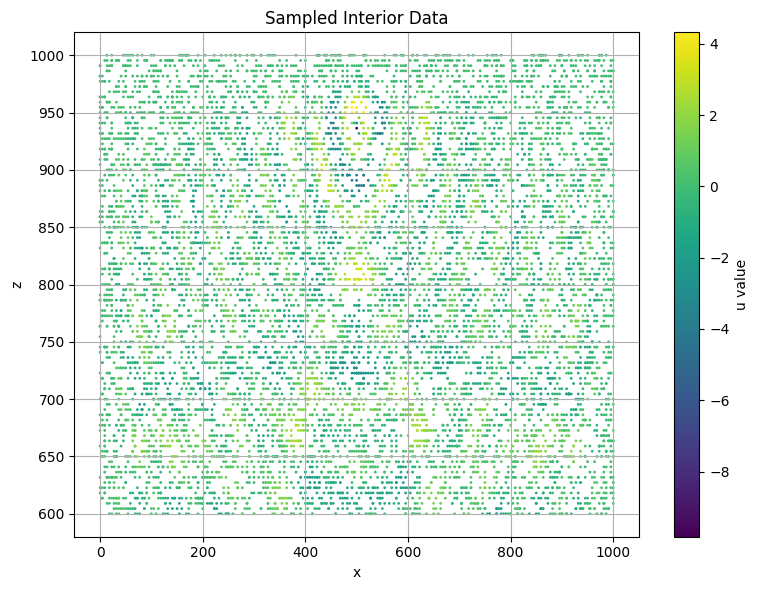

198657
>>> FASE 1: Entrenamiento con Adam <<<


Adam:   0%|          | 0/10000 [00:00<?, ?it/s]

  [Adam epoch     1] total_loss=1.5708e+00, data_loss=1.5708e+00,learning rate=0.001


Adam:   0%|          | 44/10000 [00:17<1:04:40,  2.57it/s]


KeyboardInterrupt: 

In [19]:
#En este codigo solo voy a intentar optimizar los datos de u

import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import matplotlib.colors as colors

# Configurar dispositivo CUDA
device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

###############################################################################
# 1. Clases y funciones base
###############################################################################

class MLP_u(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_u, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x
    
class MLP_k(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_units, activation_function):
        super(MLP_k, self).__init__()
        self.linear_in = nn.Linear(input_size, hidden_units)
        self.linear_out = nn.Linear(hidden_units, output_size)
        self.layers = nn.ModuleList([nn.Linear(hidden_units, hidden_units) for _ in range(hidden_layers)])
        self.act = activation_function

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.linear_in(x)
        for layer in self.layers:
            x = self.act(layer(x))
        x = self.linear_out(x)
        return x

def derivative(dy: torch.Tensor, x: torch.Tensor, order: int = 1) -> torch.Tensor:
    for _ in range(order):
        dy = torch.autograd.grad(
            dy, x,
            grad_outputs=torch.ones_like(dy),
            create_graph=True,
            retain_graph=True
        )[0]
    return dy

def set_seed(seed: int = 21):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0)

###############################################################################
# 2. Generar datos (observados y de colocalizaciÃ³n)
###############################################################################


def generate_interior_data_points(device='cpu'):
    import matplotlib.pyplot as plt
    import numpy as np
    from generate_data_points import generate_interior_data, sample_interior_data_v2

    X_data_real_aux, u_data_real_aux = generate_interior_data('data/real_part_0.0250Hz.csv','u')  # for raw data
    X_data_real, u_data_real = sample_interior_data_v2(X_data_real_aux, u_data_real_aux, num_samples=10000, device='cpu')

    X_data_real = X_data_real.detach().to(torch.float32)
    u_data_real = u_data_real.detach().to(torch.float32)


    # Create the colormap plot

    return X_data_real, u_data_real





def generate_collocation_points(N_interior=2000, N_boundary=200):
    """
    Genera puntos de entrenamiento: interior (para el residual de la PDE)
    y frontera (para la condiciÃ³n de frontera u=0), en el dominio [-3,3]^2.

    Args:
        N_interior (int): NÃºmero de puntos interiores.
        N_boundary (int): NÃºmero de puntos en la frontera (y=0).

    Returns:
        (X_int, X_bnd) en formato (torch.Tensor, torch.Tensor).
    """
    # Generate the points
    #x_int = np.random.normal(loc=500.0, scale=250, size=(N_interior, 1))
    #y_int = 1000 - np.random.exponential(scale=108, size=(N_interior, 1))
    x_int = np.random.uniform(low=0, high=1000, size=(N_interior, 1))
    y_int = np.random.uniform(low=600, high=1000, size=(N_interior, 1))
    #y_int = np.clip(y_int, -100000, -0.01)  # fuerza a estar bajo el eje x

    X_int = np.hstack((x_int, y_int))  # (N_interior,2)
    X_int = torch.tensor(X_int, dtype=torch.float32, requires_grad=True)

    # Puntos sobre la lÃ­nea y = 0 (condiciÃ³n de frontera)
    x_bnd = np.random.normal(loc=500.0, scale=250, size=(N_boundary, 1))
    y_bnd = np.full((N_boundary, 1), 975)

    X_bnd = np.hstack((x_bnd, y_bnd))
    X_bnd = torch.tensor(X_bnd, dtype=torch.float32, requires_grad=True)
    
    return X_int, X_bnd

###############################################################################
# 3. DefiniciÃ³n de las pÃ©rdidas para el problema inverso
###############################################################################

def loss_pde_inverse(model_u, model_k, X_int, w):
    u = model_u(X_int)
    c = model_k(X_int)

    grads_u = derivative(u, X_int, order=1)
    u_x = grads_u[:, 0:1]
    u_y = grads_u[:, 1:2]

    u_xx = derivative(u_x, X_int, order=1)[:, 0:1]
    u_yy = derivative(u_y, X_int, order=1)[:, 1:2]

    x = X_int[:, 0:1]
    y = X_int[:, 1:2]
    
    sin = torch.sin
    exp = torch.exp
    cos = torch.cos
    alpha = 0.5
    beta = 10
    epsilon = 0.2
    forcing = 0

    residual = (u_xx+u_yy) + (w/c)**2 - forcing
    
    return torch.mean(residual**2)

def loss_bc(model, X_bnd, alpha=0.5, beta=10):
    x = X_bnd[:, 0:1]  # Solo la coordenada x, ya que y = 0
    u_true = torch.exp(-alpha * x**2)
    u_pred = model(X_bnd)

    return torch.mean((u_pred - u_true) ** 2)

import matplotlib.pyplot as plt
import torch

def loss_data_u(model, X_data, u_data):
    u_pred = model(X_data)
        
    # Calculate and return the loss
    return torch.mean((u_pred - u_data)**2)



def loss_data_k(model, X_data, k_data):
    k_pred = model(X_data)
    return torch.mean((k_pred - k_data)**2)

###############################################################################
# 4. FunciÃ³n para graficar la soluciÃ³n y k
###############################################################################

def plot_solution_and_k(modelU, modelK, epoch, folder="figs_inverse_mixed", n_points=500):
    if not os.path.exists(folder):
        os.makedirs(folder)

    x_vals = np.linspace(-1, 1, n_points)
    y_vals = np.linspace(-1, 1, n_points)
    X_mesh, Y_mesh = np.meshgrid(x_vals, y_vals)
    XY_np = np.vstack([X_mesh.ravel(), Y_mesh.ravel()]).T
    XY_torch = torch.tensor(XY_np, dtype=torch.float32, device=device)

    with torch.no_grad():
        u_pred = modelU(XY_torch).cpu().numpy()
        k_pred = modelK(XY_torch).cpu().numpy()
    u_pred = u_pred.reshape(n_points, n_points)
    k_pred = k_pred.reshape(n_points, n_points)
    alpha = 0.5
    beta = 10
    epsilon = 0.2

    u_true = np.exp(-alpha * (X_mesh**2 + Y_mesh**2)) * np.cos(beta * Y_mesh)
    k_true = 1 + 2 / (1 + np.exp(-(Y_mesh+1) / epsilon))


    # Create a 2D figure with 4 subplots
    fig = plt.figure(figsize=(12, 10))
    
    
    # 2D plot for PINN u
    ax1 = fig.add_subplot(2, 2, 1)
    im1 = ax1.pcolormesh(X_mesh, Y_mesh, u_pred, cmap='seismic', shading='auto')
    ax1.set_title(f"PINN u (epoch {epoch})")
    fig.colorbar(im1, ax=ax1)
    
    # 2D plot for Analytic u
    ax2 = fig.add_subplot(2, 2, 2)
    im2 = ax2.pcolormesh(X_mesh, Y_mesh, u_true, cmap='seismic', shading='auto')
    ax2.set_title("Analytic u")
    fig.colorbar(im2, ax=ax2)
    
    # 2D plot for PINN k
    ax3 = fig.add_subplot(2, 2, 3)
    im3 = ax3.pcolormesh(
        X_mesh, Y_mesh, k_pred,
        cmap='GnBu', shading='auto'
    )
    ax3.set_title(f"PINN k (epoch {epoch})")
    cbar = fig.colorbar(im3, ax=ax3)
    
    # 2D plot for Analytic k
    ax4 = fig.add_subplot(2, 2, 4)
    im4 = ax4.pcolormesh(X_mesh, Y_mesh, k_true, cmap='GnBu', shading='auto')
    ax4.set_title("Analytic k")
    fig.colorbar(im4, ax=ax4)
    
    plt.tight_layout()
    plt.savefig(os.path.join(folder, f"solution_epoch_{epoch}.png"))
    plt.close(fig)

###############################################################################
# 5. Entrenamiento
###############################################################################

def train_inverse_pinn_mixed(
    modelU, modelK, w,
    X_int, X_bnd, 
    X_data, u_data,
    adam_epochs=10000,
    lbfgs_iterations=500,
    lr_adam=1e-4,
    lr_lbfgs=0.5,
    lambda_bc=5.0, 
    lambda_data=1.0,
    plot_every=100
):

    adam_loss_history = []
    lbfgs_loss_history = []

    optimizer_adam = torch.optim.Adam(list(modelU.parameters()), lr=lr_adam)

    print(">>> FASE 1: Entrenamiento con Adam <<<")
    for epoch in tqdm(range(1, adam_epochs+1), desc="Adam"):
        optimizer_adam.zero_grad()

        data_loss_val_u = loss_data_u(modelU, X_data, u_data)

        total_loss = data_loss_val_u 
        total_loss.backward()
        optimizer_adam.step()
        

        if epoch % plot_every == 0 or epoch == 1 or epoch == adam_epochs:
            adam_loss_history.append(total_loss.item())
            print(f"  [Adam epoch {epoch:5d}] total_loss={total_loss.item():.4e}, "
                  f"data_loss={data_loss_val_u.item():.4e},"
                  f"learning rate={lr_adam}")
            plot_solution_and_k(modelU, modelK, epoch, folder=f"exp1/figs_inverse_w={w}")

    return modelU, modelK, adam_loss_history, lbfgs_loss_history


###############################################################################
# 6. EjecuciÃ³n principal
###############################################################################

if __name__ == "__main__":
    set_seed(21)

    X_int, X_bnd = generate_collocation_points(N_interior=15000, N_boundary=500)
    X_data, u_data= generate_interior_data_points()
    
    x_sampled = X_data[:, 0].detach().numpy()
    z_sampled = X_data[:, 1].detach().numpy()
    u_sampled = u_data.cpu().detach().numpy()

    # Create scatter plot
    plt.figure(figsize=(8, 6))
    sc = plt.scatter(x_sampled, z_sampled, c=u_sampled, cmap='viridis', s=1)
    plt.colorbar(sc, label='u value')
    plt.xlabel('x')
    plt.ylabel('z')
    plt.title('Sampled Interior Data')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    model_u = MLP_u(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.SiLU()

    ).to(device)
    model_u.apply(init_weights)

    model_k = MLP_k(
        input_size=2,
        output_size=1,
        hidden_layers= 12,
        hidden_units=128,
        activation_function=nn.Tanh()
    ).to(device)
    model_k.apply(init_weights)
    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse")

    print(sum(p.numel() for p in model_u.parameters() if p.requires_grad) )
    w = 0.11

    model_u, model_k, adam_LOSS, LGFGS_LOSS = train_inverse_pinn_mixed(
            model_u, model_k, w,
            X_int, X_bnd,
            X_data, u_data,
            adam_epochs=10000,
            lbfgs_iterations=500,
            lr_adam=1e-03,
            lr_lbfgs=0.5,
            lambda_bc=1,
            lambda_data=100,
            plot_every=100)


    plot_solution_and_k(model_u, model_k, 0, folder="figs_inverse_mixed_final")